In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from tqdm.auto import tqdm
from multiprocessing import Pool

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
saved = nl.io.load.hdf5('../../data/20250302_minflux_H2B_clean.h5')

In [3]:
data       = saved['data']
conditions = saved['conditions']
data.makeSelection()

# Plot MSDs

H2B, U2OS, DRB 1303


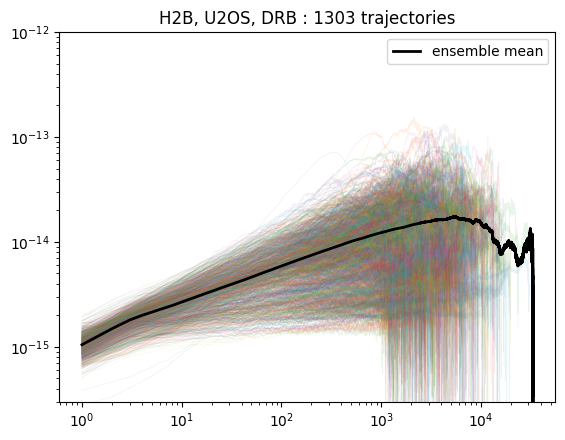

H2B, U2OS, ICRF 1395


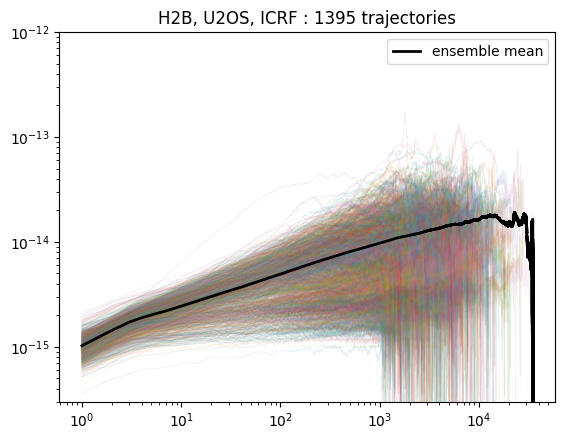

H2B, U2OS, TSA 1373


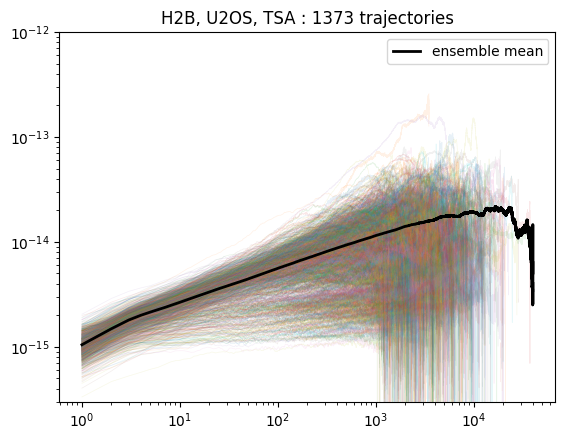

H2B, U2OS, ctrl 1517


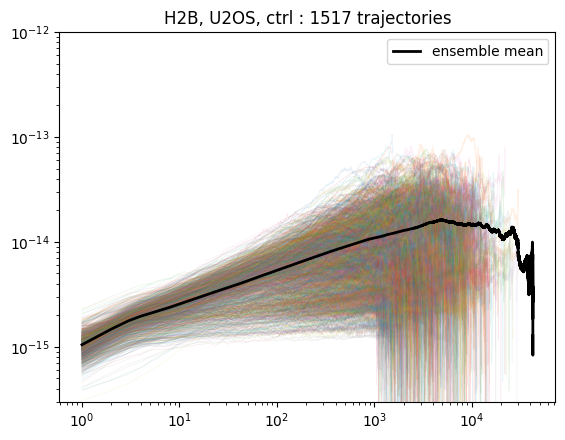

H2B, mESC, DRB 525


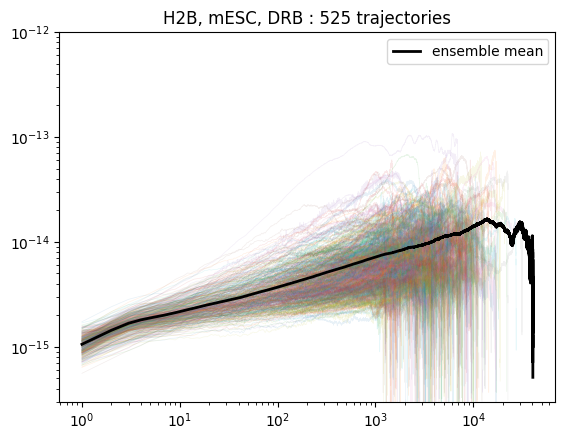

H2B, mESC, ICRF 585


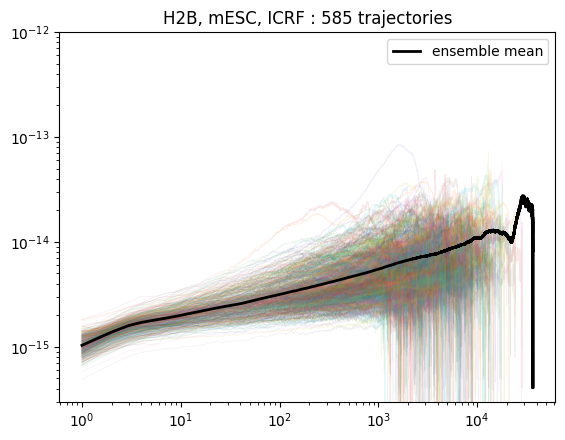

H2B, mESC, TSA 485


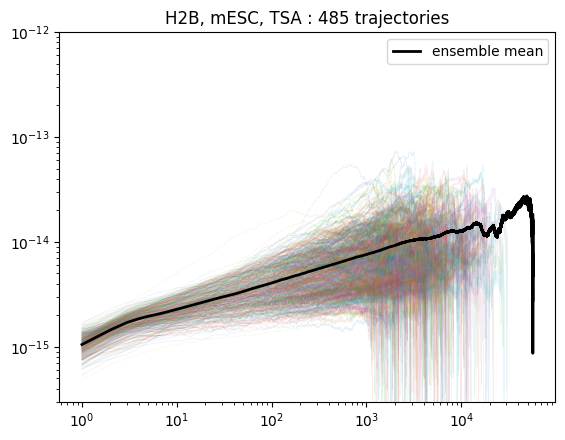

H2B, mESC, ctrl 666


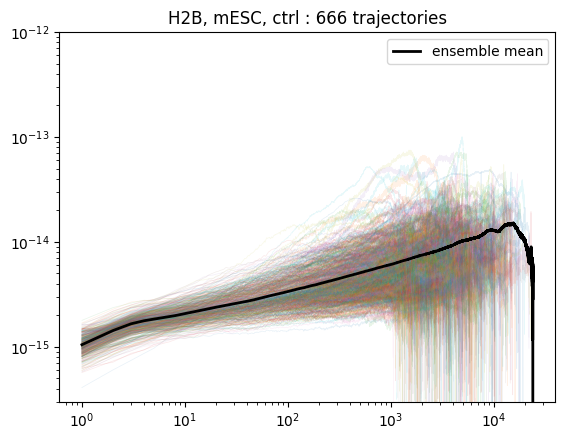

In [4]:
for cond in conditions:
    data.makeSelection(cond)
    print(cond, len(data))

    nl.plot.msd_overview(data, linewidth=0.5, alpha=0.1)
    plt.title(f'{cond} : {len(data)} trajectories')
    plt.ylim([3e-16, 1e-12])
    plt.show()

Especially for U2OS, it looks like there are some "stuck" trajectories. It's probably going to be hard to judge whether those are real or some artefact; but let's at least try to get an overview and maybe an idea of what this is.

In [5]:
cond = 'H2B, U2OS, ctrl'
data.makeSelection(cond)
len(data)

1517

# Powerlaw fits

In [6]:
def chop(traj, dt=1, L=200, Fmin=2):
    if dt is None:
        dt = traj.meta['Δt']
    
    def chop_traj(traj, dt=dt):
        if 'Δt' in traj.meta:
            dt = traj.meta['Δt']
            
        chops = []
        i0 = 0
        while i0 < len(traj):
            i1 = i0+L
            chop = traj.data[:, i0:min(i1, len(traj)), :]
            try:
                t_start = np.nonzero(~np.any(np.isnan(chop), axis=(0, 2)))[0][0]
            except IndexError: # no valid entries in this chop
                new_traj = nl.Trajectory(chop[:, [0]])
            else:
                new_traj = nl.Trajectory(chop[:, t_start:])
                
            new_traj.meta['Δt'] = dt
            chops.append(new_traj)

            i0 = i1
            
        return chops
    
    chops = chop_traj(traj)
    out = nl.TaggedSet(chops, hasTags=False)
    while len(chops) > 1:
        cg_traj = nl.Trajectory(np.stack([traj.data[:, 0] for traj in chops], axis=1))
        cg_traj.meta['Δt'] = L*chops[0].meta['Δt']
        chops = chop_traj(cg_traj)
        for traj in chops:
            out.add(traj)
    
    # Clean out useless trajectories
    out.makeSelection(lambda traj, _: traj.F < Fmin)
    out.deleteSelection()
    return out

In [7]:
def parfun(args):
    i, traj = args
    
    ds = chop(traj)
    if len(ds) == 0:
        return i, None
        
    fit = bayesmsd.lib.NPFit(ds,
                             motion_blur_f=1,
                             parametrization='(log(αΓ), α)',
                            )
    # fit.parameters['log(σ²) (dim 0)'].fix_to = -np.inf
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fit.verbosity = 0
    
    profiler = bayesmsd.Profiler(fit)
    profiler.verbosity = 0
    
    # return i, fit.run()
    return i, profiler.find_MCI()

data.makeSelection()
todo = list(enumerate(data))
with Pool() as mypool:
    imap = mypool.imap_unordered(parfun, todo)
    imap = tqdm(imap, total=len(todo))
    for i, mci in imap:
        # data[i].meta['res'] = res
        data[i].meta['mci'] = mci

  0%|          | 0/7849 [00:00<?, ?it/s]

In [8]:
data.makeSelection()
data.refineSelection(lambda traj, _: traj.meta['mci'] is None)
print(len(data), 'trajectories were too short to fit')

0 trajectories were too short to fit


In [9]:
data.makeSelection()
nl.io.write.hdf5({
    'mcis' : [traj.meta['mci'] for traj in data],
    'description' : """
Fit/Profiler results for single-trajectory NPFits to 20230302_minflux_H2B_clean.h5

ATTENTION: these are sorted, in the same order as trajectories in the data set.
Make sure to associate them correctly when loading!

Setup for each trajectory `traj` as follows:
```
ds = chop(traj)
fit = bayesmsd.lib.NPFit(ds,
                         motion_blur_f=1,
                         parametrization='(log(αΓ), α)',
                        )
# fit.parameters['log(σ²) (dim 0)'].fix_to = -np.inf
fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
fit.verbosity = 0

profiler = bayesmsd.Profiler(fit)
```
Note that the data do not have .meta['Δt'] set, so f=1 is full motion blur.
"""[1:-1]}, '../../data/20250302_single-traj_NPFit_H2B_clean.h5')

# Analysis

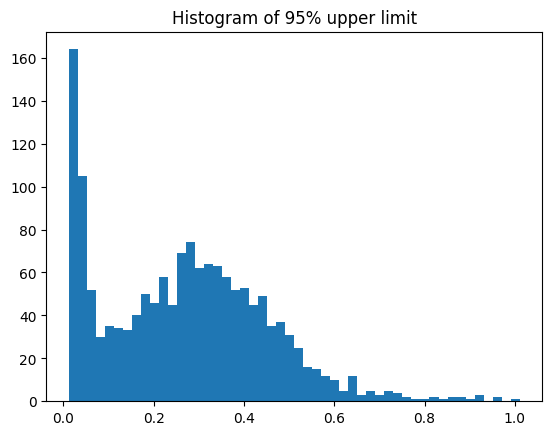

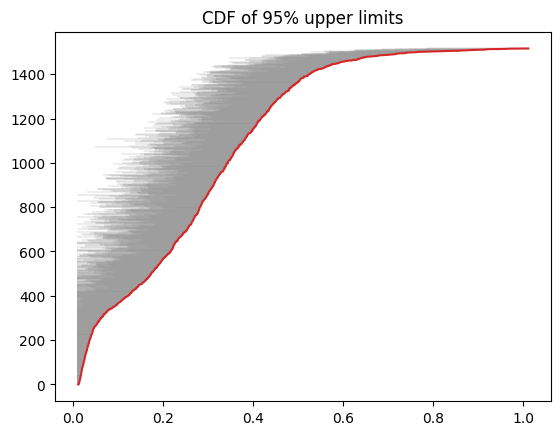

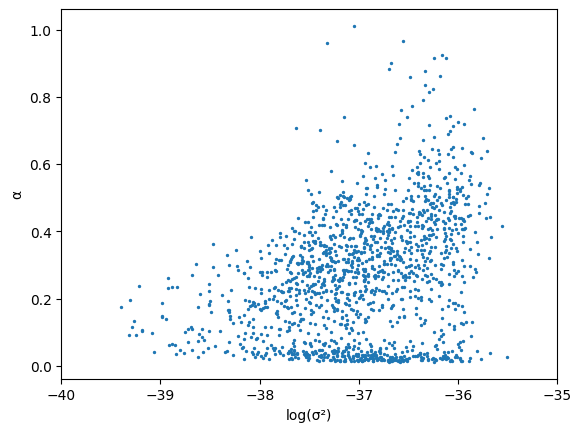

In [10]:
data.makeSelection('H2B, U2OS, ctrl')
alphas = np.array([traj.meta['mci']['α (dim 0)'][1][1] for traj in data])
log_s2 = np.array([traj.meta['mci']['log(σ²) (dim 0)'][0] for traj in data])

plt.hist(alphas, bins=50)
plt.title('Histogram of 95% upper limit')
plt.show()

left  = np.array([traj.meta['mci']['α (dim 0)'][1][0] for traj in data])
right = np.array([traj.meta['mci']['α (dim 0)'][1][1] for traj in data])
ind = np.argsort(alphas)
y = np.arange(len(alphas))
plt.hlines(y, left[ind], right[ind],
           color='gray', linewidth=0.2,
          )
plt.plot(alphas[ind], y, color='tab:red')
plt.title('CDF of 95% upper limits')
plt.show()

plt.scatter(log_s2, alphas, s=2)
plt.xlim([-40, -35])
plt.xlabel('log(σ²)')
plt.ylabel('α')
plt.show()

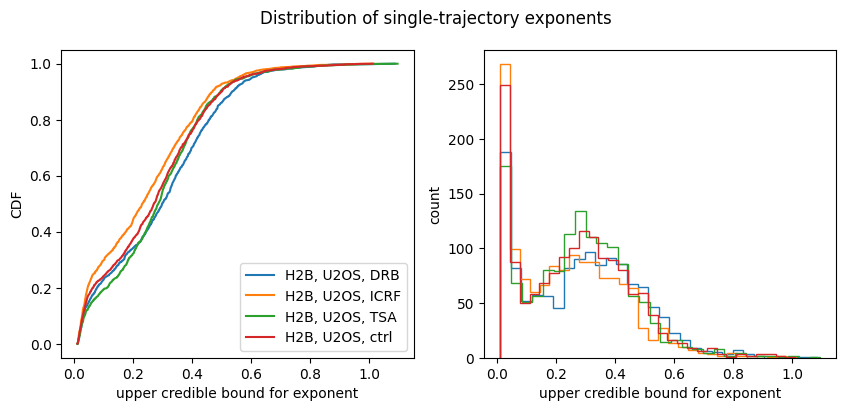

In [11]:
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

for i, cond in enumerate(conditions):
    if 'U2OS' not in cond:
        continue
        
    color=f'C{i}'
        
    # for rep in ['rep=1', 'rep=2', 'rep=3']:
    #     data.makeSelection([cond, rep], logic=all)
    data.makeSelection(cond)
    # data.refineSelection('rep=1')
    alphas = np.array([traj.meta['mci']['α (dim 0)'][1][1] for traj in data])

    ax = axs[0]
    ind = np.argsort(alphas)
    y = np.arange(len(alphas))
    y = y / y[-1]
    ax.plot(alphas[ind], y, label=cond, color=color)
    
    ax = axs[1]
    ax.hist(alphas, bins=30, color=color, histtype='step')

ax = axs[0]
ax.legend()
ax.set_xlabel('upper credible bound for exponent')
ax.set_ylabel('CDF')

ax = axs[1]
ax.set_xlabel('upper credible bound for exponent')
ax.set_ylabel('count')

fig.suptitle('Distribution of single-trajectory exponents')

plt.show()

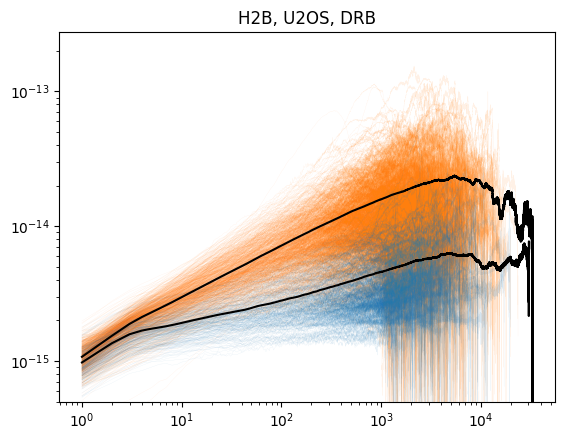

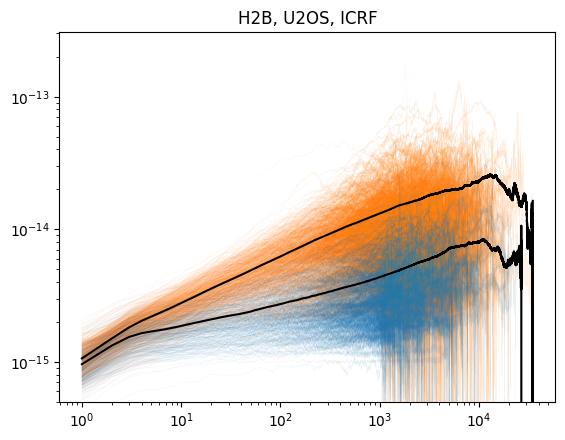

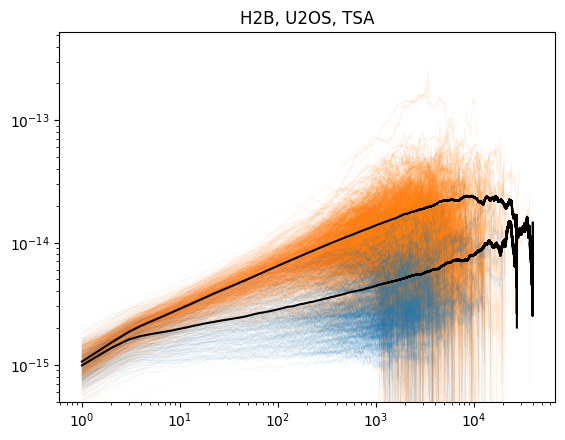

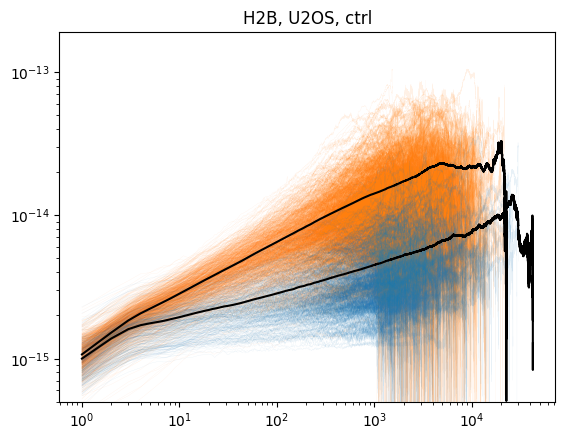

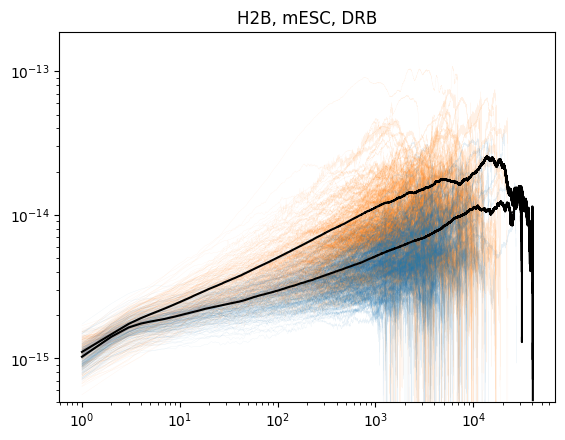

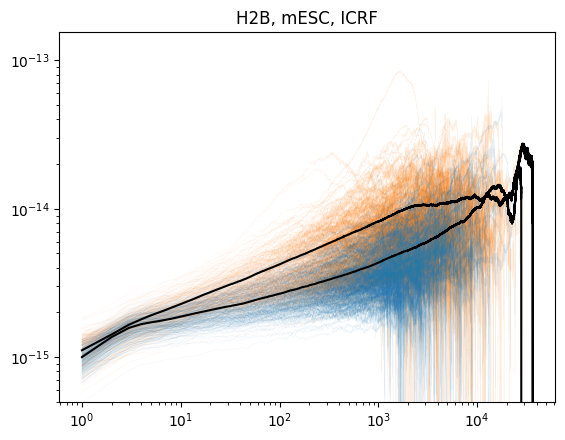

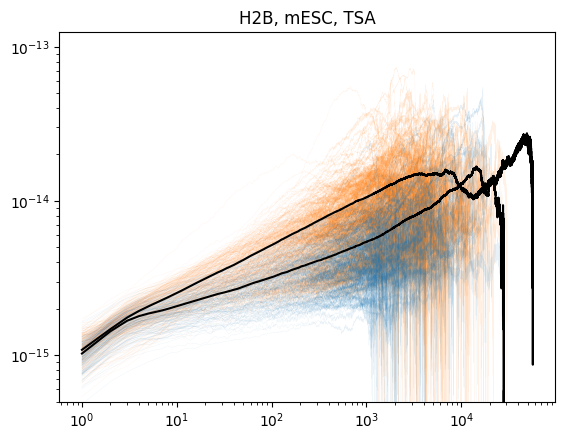

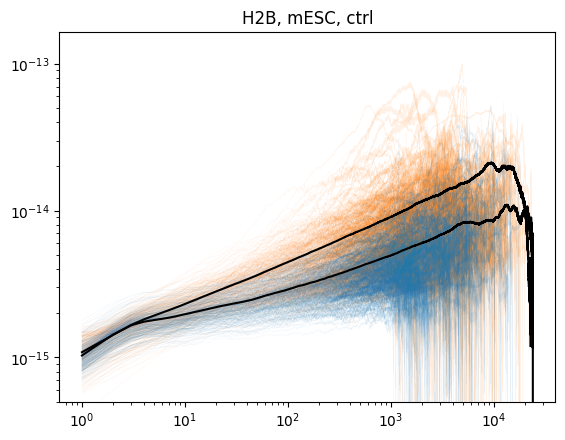

In [12]:
bounds = [0, 0.1, 2.]

for cond in conditions:
    for i, b0 in enumerate(bounds[:-1]):
        b1 = bounds[i+1]

        data.makeSelection(cond)
        data.refineSelection(lambda traj, _: b0 <= traj.meta['mci']['α (dim 0)'][1][1] < b1)

        for traj in data:
            msd = nl.analysis.MSD(traj)
            plt.plot(np.arange(1, len(msd)), msd[1:],
                     color=f'C{i}', linewidth=0.2, alpha=0.1,
                     zorder=10-i,
                    )
        
        msd = nl.analysis.MSD(data)
        plt.plot(np.arange(1, len(msd)), msd[1:],
                 color='k', zorder=11,
                )

    plt.xscale('log')
    plt.yscale('log')
    plt.title(cond)
    plt.ylim([5e-16, None])

    plt.show()

In [13]:
data.makeSelection(lambda traj, _: traj.meta['mci']['α (dim 0)'][1][1] < 0.1)
data.addTags('low α')
data.makeSelection('low α', logic=lambda x: not any(x))
data.addTags('high α')
data.makeSelection()

a_colors = {
    'low α'  : 'tab:blue',
    'high α' : 'tab:orange',
}

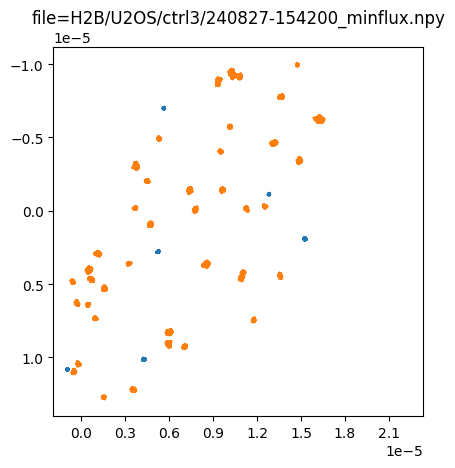

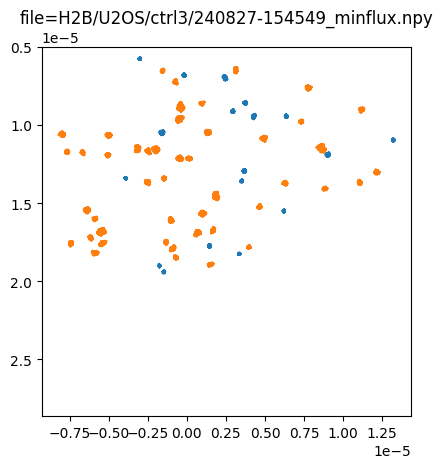

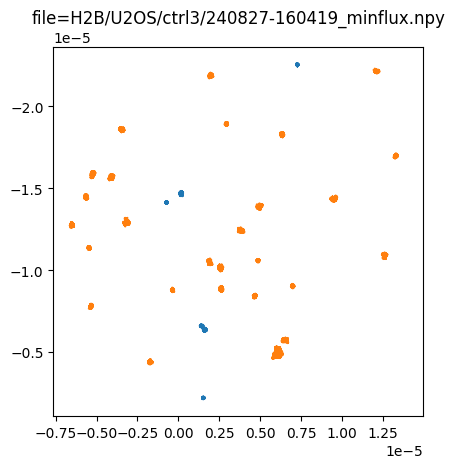

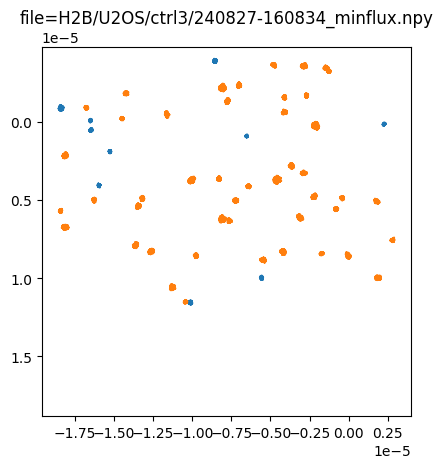

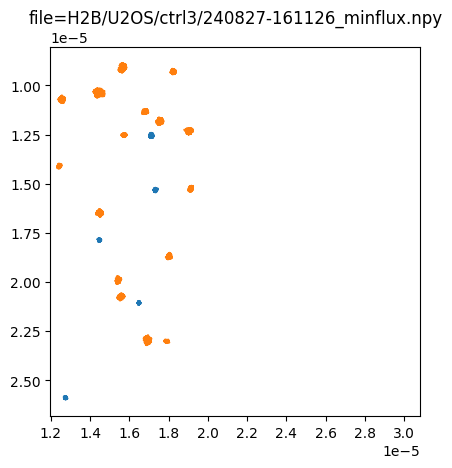

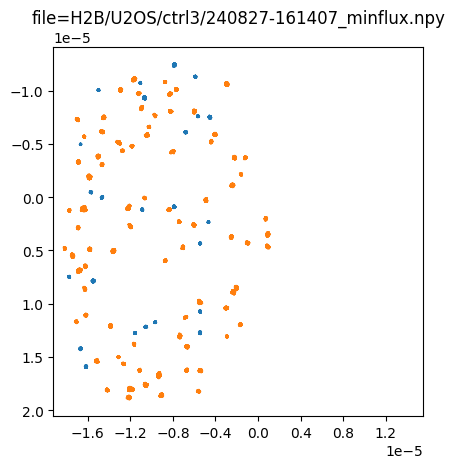

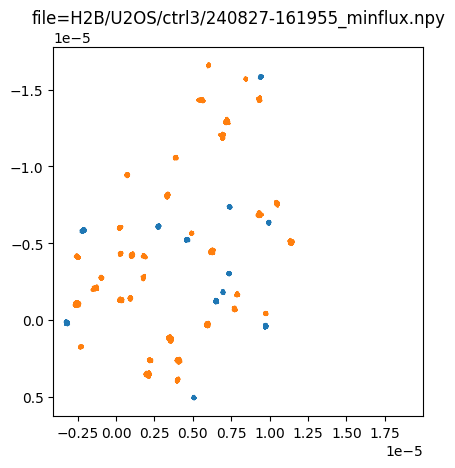

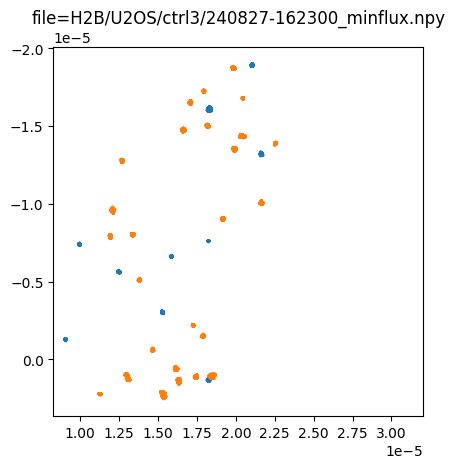

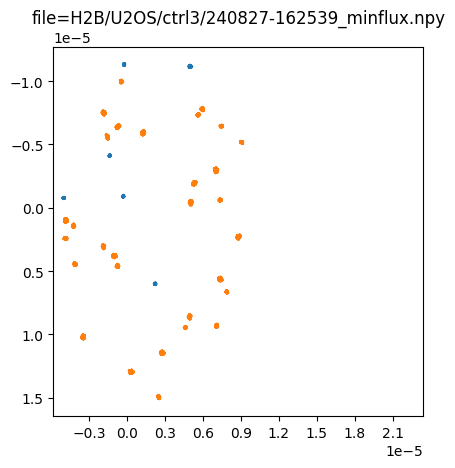

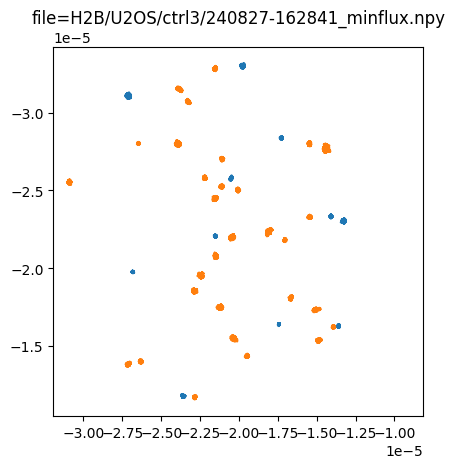

In [14]:
data.makeSelection(['U2OS', 'ctrl3'], logic=all)
filetags = sorted({tag for tag in data.tagset() if tag.startswith('file=')})

for tag in filetags:
    for lowhigh in a_colors:
        data.makeSelection([tag, lowhigh], logic=all)
        for traj in data:
            nl.plot.spatial(traj, color=a_colors[lowhigh])

    plt.title(tag)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.show()

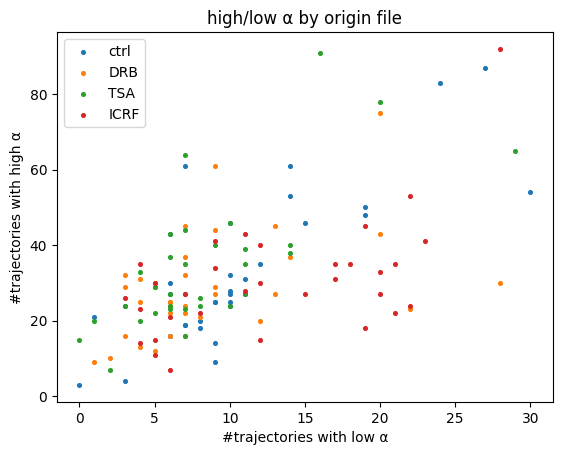

In [15]:
for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:
    data.makeSelection(['U2OS', treatment], logic=all)
    filetags = sorted({tag for tag in data.tagset() if tag.startswith('file=')})

    ns = {}
    for tag in filetags:
        ns[tag] = np.array([0, 0], dtype=int)
        for i, lowhigh in enumerate(a_colors):
            data.makeSelection([tag, lowhigh], logic=all)
            ns[tag][i] = len(data)

    n_low  = np.array([ns[tag][0] for tag in filetags])
    n_high = np.array([ns[tag][1] for tag in filetags])

    plt.scatter(n_low, n_high, s=7, label=treatment)

plt.legend()
plt.xlabel('#trajectories with low α')
plt.ylabel('#trajectories with high α')
plt.title('high/low α by origin file')

plt.show()

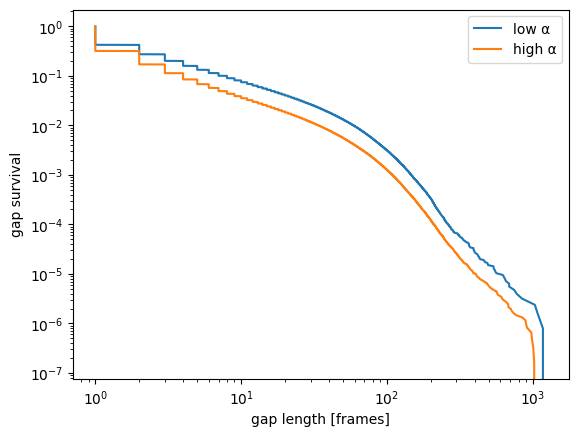

In [16]:
# Gap distribution by high/low α
gaps = {}
for lowhigh in a_colors:
    data.makeSelection(['U2OS', lowhigh], logic=all)
    gaps[lowhigh] = []
    for traj in data:
        ind = np.nonzero(np.isnan(traj.abs()[:][:, 0]))[0]
        gaps[lowhigh].append(np.diff(ind))
    
    gaps[lowhigh] = np.sort(np.concatenate(gaps[lowhigh]))
    
    y = 1-np.linspace(0, 1, len(gaps[lowhigh]))
    plt.plot(gaps[lowhigh], y, color=a_colors[lowhigh], label=lowhigh)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gap length [frames]')
plt.ylabel('gap survival')

plt.show()